# 🧠 RNN (Recurrent Neural Network) 완전 정리

---

## 📌 1. 개념 요약

RNN(Recurrent Neural Network, 순환 신경망)은 **시퀀스(순서가 있는 데이터)** 를 처리하기 위한 신경망입니다.  
이전 시점의 정보를 현재 시점 계산에 반영하는 구조를 가집니다.

예를 들어, 문장을 단어 단위로 처리할 때  
현재 단어뿐 아니라 **이전 단어들의 의미**도 반영해야 문맥을 이해할 수 있습니다.

---


## 🔄 3. 작동 원리 (쉬운 설명)

1. 첫 번째 입력 \( x_1 \)이 들어옴  
   → 초기 은닉상태 \( h_0 = 0 \)과 함께 새로운 은닉상태 \( h_1 \) 계산  
2. 다음 입력 \( x_2 \)이 들어옴  
   → \( h_1 \)과 결합해서 \( h_2 \) 계산  
3. 이런 식으로 순차적으로 진행  
   → 마지막 은닉상태 \( h_T \)가 “전체 문맥의 요약본”

즉, **RNN은 기억이 있는 신경망**이에요.

---

## 🧱 5. 입력과 출력의 형태

| 항목           | 형태                                                  | 설명                    |
| ------------ | --------------------------------------------------- | --------------------- |
| 입력 `x`       | `(batch, seq_len, input_size)`                      | 입력 시퀀스 데이터            |
| 출력 `out`     | `(batch, seq_len, hidden_size)`                     | 각 시점의 은닉 출력 (T개의 h_t) |
| 마지막 은닉 `h_n` | `(num_layers * num_directions, batch, hidden_size)` | 마지막 시점의 은닉 상태         |

---

## ⚙️ 7. 주요 매개변수(Parameter) 상세 설명

| 매개변수              | 자료형   | 기본값    | 설명                                       |
| ----------------- | ----- | ------ | ---------------------------------------- |
| **input_size**    | int   | 필수     | 각 시점 입력의 특성(feature) 개수                  |
| **hidden_size**   | int   | 필수     | 은닉층 뉴런(출력 벡터)의 크기                        |
| **num_layers**    | int   | 1      | RNN 층의 개수 (층이 깊을수록 복잡한 패턴 학습 가능)         |
| **nonlinearity**  | str   | 'tanh' | 활성화 함수 선택 (`'tanh'` or `'relu'`)         |
| **bias**          | bool  | True   | 각 가중치에 편향(bias) 항 추가 여부                  |
| **batch_first**   | bool  | False  | 입력 텐서 첫 차원이 배치인지 여부                      |
| **dropout**       | float | 0.0    | 층 사이에 드롭아웃 적용 비율 (층 ≥ 2일 때만 작동)          |
| **bidirectional** | bool  | False  | 양방향 RNN 사용 여부 (True 시 순/역방향 두 개의 은닉층 생성) |


## 🧠 8. RNN의 하이퍼파라미터 선택 팁

| 항목                | 설명                                      |
| ----------------- | --------------------------------------- |
| **hidden_size**   | 작으면 정보가 부족, 너무 크면 과적합 / 느림 (보통 32~128)  |
| **num_layers**    | 시계열 복잡도에 따라 1~3 정도 사용                   |
| **nonlinearity**  | ‘tanh’가 기본, relu는 더 빠르지만 때로는 불안정        |
| **dropout**       | 과적합 방지를 위해 0.2~0.5 권장 (층이 2 이상일 때)      |
| **bidirectional** | 양방향 문맥이 필요한 NLP 등에서 사용 (시계열 예측은 단방향 선호) |






In [19]:
# ============================================================
# RNN(기본형)으로 단변량 시계열의 "다음 1스텝" 예측하기 (PyTorch)
# - 데이터: 사인파 + 노이즈 (인공 데이터)
# - 윈도우: 과거 window개를 보고 다음 1개 값을 예측 (many-to-one 회귀)
# - 모델: nn.RNN + Linear(출력 1)
# - 포인트: 텐서 모양 (batch, seq_len, input_size), 표준화, gradient clipping
# ============================================================

import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [20]:

# ---------------------------
# 0) 재현성(결과 일관성) 설정
# ---------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cpu


In [21]:

# ---------------------------
# 1) 데이터 생성: 사인파 + 노이즈
# ---------------------------
def make_sine(n=3000, freq=0.02, noise=0.05):
    """
    n    : 전체 길이(시점 수)
    freq : 사인 주파수 (작을수록 주기가 길어짐)
    noise: 가우시안 노이즈 표준편차 규모
    반환 : 길이 n의 torch.Tensor (shape: (n,))
    """
    xs = torch.arange(n).float()
    ys = torch.sin(2 * math.pi * freq * xs) + noise * torch.randn(n)
    return ys

series = make_sine(n=4000, freq=0.015, noise=0.08)  # (4000,)
series

tensor([ 0.1542,  0.2131,  0.2594,  ..., -0.2528, -0.1370,  0.0563])

In [22]:

# ---------------------------
# 2) 학습/검증 분할 + 표준화
# ---------------------------
# 시계열에서 일반적으로 "앞부분을 학습, 뒷부분을 검증"으로 나눔(시간 누수 방지)
split_idx = int(len(series) * 0.8)
train_series = series[:split_idx]       # 학습 구간
val_series   = series[split_idx:]       # 검증 구간

# 표준화(학습 구간 통계만 사용) → 평균0, 표준편차1로 맞춰 학습 안정화
mean = train_series.mean()
std  = train_series.std()
train_series = (train_series - mean) / (std + 1e-8)
val_series   = (val_series   - mean) / (std + 1e-8)
train_series

tensor([ 0.2160,  0.2988,  0.3639,  ..., -0.2979, -0.2855, -0.1484])

In [23]:
# ---------------------------
# 3) 윈도우 데이터셋
# ---------------------------
class WindowDataset(Dataset):
    """
    단변량 시계열에서
    X: 이전 window개 시점(입력 시퀀스)
    y: 그 다음 1개 시점(정답)
    를 만드는 Dataset.
    """
    def __init__(self, series: torch.Tensor, window: int):
        """
        series: (N,) 형태의 1D 텐서 (이미 표준화된 구간)
        window: 과거 몇 개를 볼지 (슬라이딩 윈도우 길이)
        """
        self.series = series
        self.window = window
        # 유효 샘플 개수: 마지막 타깃 y를 만들려면 index 최대가 len(series)-1,
        # 입력은 [i, i+window-1], 타깃은 i+window → i는 0..len-1-window 까지 가능
        self.n = len(series) - window

    # __len__, __getitem__ 함수는 DataLoader에서 사용이 되는 특수 함수
    def __len__(self):
        return max(self.n, 0)  # 안전

    def __getitem__(self, idx):
        """
        반환:
          X: shape (window, 1)  → RNN 입력을 위해 마지막 차원을 '특징 수'로 둠
          y: shape (1,)         → 다음 1스텝 값(스칼라)
        """
        x = self.series[idx: idx + self.window].unsqueeze(-1)  # (window,) → (window, 1)
        y = self.series[idx + self.window]                     # 스칼라
        return x, y.unsqueeze(0)                               # y를 (1,)로 통일

window = 48  # 한 주기 이상을 포착하도록 넉넉히(데이터 주기에 맞춰 조정)
train_ds = WindowDataset(train_series, window=window)
val_ds   = WindowDataset(val_series,   window=window)


**DataLoader**는 PyTorch에서 Dataset을 효율적으로 배치 단위로 꺼내주는 반복자(iterator) 입니다. 학습 루프에 딱 맞는 형태로 데이터를 공급해 주는 “미들웨어”라고 보면 돼요.

DataLoader가 해주는 일

배치 만들기: 샘플들을 모아 (batch, …) 텐서로 묶어 줌.

섞기(shuffle): 에폭마다 데이터 순서를 랜덤화(일반화에 도움).

병렬 로드(num_workers): 여러 프로세스로 디스크에서 동시에 읽고 전처리 → GPU가 놀지 않게 I/O를 겹침.

고정 메모리(pinned memory): pin_memory=True면 CPU→GPU 전송을 더 빠르게.

맞춤 배치 조립(collate_fn): 길이 제각각 시퀀스 패딩 등 배치 구성 방법을 커스터마이즈.

샘플러/배치샘플러: 샘플 선택 순서/방식을 직접 제어(불균형 데이터, 분산학습 등).
| 파라미터                        |      기본 | 설명/언제 쓰나                                          |
| --------------------------- | ------: | ------------------------------------------------- |
| `batch_size`                |     `1` | 한 번에 꺼내는 샘플 수(메모리/GPU에 맞게 조절: 32/64/128…)         |
| `shuffle`                   | `False` | 에폭마다 순서 섞기(학습셋에서 `True`)                          |
| `num_workers`               |     `0` | **병렬 데이터 로딩 프로세스 수**. CPU 코어 여유 있으면 2~8 시도        |
| `pin_memory`                | `False` | GPU 사용 시 `True`로 두면 CPU→GPU 전송이 빨라짐               |
| `drop_last`                 | `False` | 마지막 “짧은” 배치를 버릴지(배치 정규화/스텝 일정 유지)                 |
| `collate_fn`                |  `None` | 배치 조립 함수(패딩, 커스텀 전처리)                             |
| `sampler` / `batch_sampler` |  `None` | 샘플/배치 선택 전략 직접 제어(불균형, 분산학습)                      |
| `persistent_workers`        | `False` | 여러 에폭 동안 worker 유지(초기화 비용 절감, `num_workers>0`일 때) |
| `generator`                 |  `None` | 재현성 위해 시드 고정 시 사용                                 |


In [24]:

# DataLoader: 학습은 섞고(shuffle=True), 검증은 순서 유지(shuffle=False)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=256, shuffle=False, drop_last=False)
train_dl

In [25]:

# ---------------------------
# 4) RNN 모델 정의 (기본형)
# ---------------------------
class RNNRegressor(nn.Module):
    """
    nn.RNN(기본형)만 사용해서 마지막 은닉 상태를 1차원으로 회귀 예측.
    - 입력 x shape:  (batch, seq_len=window, input_size=1)
    - RNN out:       (batch, seq_len, hidden_size)  ← 모든 시점의 은닉 출력
    - h_n:           (num_layers * num_directions, batch, hidden_size)
    - 우리는 마지막 은닉 h_n[-1]만 뽑아 Linear로 1차원 회귀.
    """
    def __init__(
        self,
        input_size: int = 1,
        hidden_size: int = 64,
        num_layers: int = 1,
        nonlinearity: str = "tanh",
        dropout: float = 0.0,
        bidirectional: bool = False,
        batch_first: bool = True
    ):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,  # 'tanh' 또는 'relu'
            bias=True,
            batch_first=batch_first,    # 입력/출력 첫 차원이 배치가 되도록
            dropout=dropout,            # ※ num_layers>=2일 때만 동작
            bidirectional=bidirectional # 양방향 RNN 여부
        )
        out_features = hidden_size * (2 if bidirectional else 1)
        self.head = nn.Linear(out_features, 1)  # 스칼라 회귀

    def forward(self, x):
        """
        x: (batch, window, 1)
        반환: (batch, 1)
        """
        # out: 모든 시점 은닉, h_n: 마지막 시점(층별/방향별) 은닉
        out, h_n = self.rnn(x)  # out:(B,T,H), h_n:(L*D, B, H)
        # 마지막 레이어(+방향)의 은닉만 사용
        last_hidden = h_n[-1]     # (B, H) 또는 (B, 2H) if bidirectional
        yhat = self.head(last_hidden)  # (B, 1)
        return yhat

model = RNNRegressor(
    input_size=1,
    hidden_size=64,
    num_layers=1,
    nonlinearity="tanh",
    dropout=0.0,
    bidirectional=False,
    batch_first=True
)
model

RNNRegressor(
  (rnn): RNN(1, 64, batch_first=True)
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [26]:

# ---------------------------
# 5) 학습 준비
# ---------------------------
criterion = nn.MSELoss()                    # 회귀이므로 MSE 손실
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam 권장
max_grad_norm = 1.0                         # gradient 폭주 방지용 클리핑

# 검증 단계 함수
def evaluate_mse(dataloader):
    model.eval()
    total_loss, total_n = 0.0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device).float()   # (B, T, 1)
            y = y.to(device).float()   # (B, 1)
            yhat = model(X)            # (B, 1)
            loss = criterion(yhat, y)
            total_loss += loss.item() * y.size(0)
            total_n += y.size(0)
    return total_loss / max(total_n, 1)

# ---------------------------
# 6) 학습 루프
# ---------------------------
epochs = 20
train_history, val_history = [], []

for epoch in range(1, epochs+1):
    model.train()
    running = 0.0
    n_seen = 0

    for X, y in train_dl:
        X = X.to(device).float()  # 입력 시퀀스 (B,T,1)
        y = y.to(device).float()  # 타깃        (B,1)

        optimizer.zero_grad()
        yhat = model(X)                 # (B,1)
        loss = criterion(yhat, y)       # 스칼라
        loss.backward()

        # gradient clipping: RNN에서 길거나 불안정한 경우 폭주 방지
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        running += loss.item() * y.size(0)
        n_seen += y.size(0)

    train_mse = running / max(n_seen, 1)
    val_mse   = evaluate_mse(val_dl)
    train_history.append(train_mse)
    val_history.append(val_mse)
    print(f"[Epoch {epoch:02d}] train_mse={train_mse:.6f} | val_mse={val_mse:.6f}")


[Epoch 01] train_mse=0.219640 | val_mse=0.028580
[Epoch 02] train_mse=0.025127 | val_mse=0.021551
[Epoch 03] train_mse=0.021006 | val_mse=0.017148
[Epoch 04] train_mse=0.017634 | val_mse=0.020168
[Epoch 05] train_mse=0.017034 | val_mse=0.016248
[Epoch 06] train_mse=0.016669 | val_mse=0.017153
[Epoch 07] train_mse=0.016557 | val_mse=0.015081
[Epoch 08] train_mse=0.016090 | val_mse=0.015516
[Epoch 09] train_mse=0.016606 | val_mse=0.015275
[Epoch 10] train_mse=0.016029 | val_mse=0.015069
[Epoch 11] train_mse=0.015241 | val_mse=0.015135
[Epoch 12] train_mse=0.015595 | val_mse=0.015444
[Epoch 13] train_mse=0.016153 | val_mse=0.014564
[Epoch 14] train_mse=0.015567 | val_mse=0.014769
[Epoch 15] train_mse=0.015400 | val_mse=0.015303
[Epoch 16] train_mse=0.016202 | val_mse=0.015461
[Epoch 17] train_mse=0.015198 | val_mse=0.014834
[Epoch 18] train_mse=0.015443 | val_mse=0.015929
[Epoch 19] train_mse=0.016409 | val_mse=0.015005
[Epoch 20] train_mse=0.014917 | val_mse=0.017810


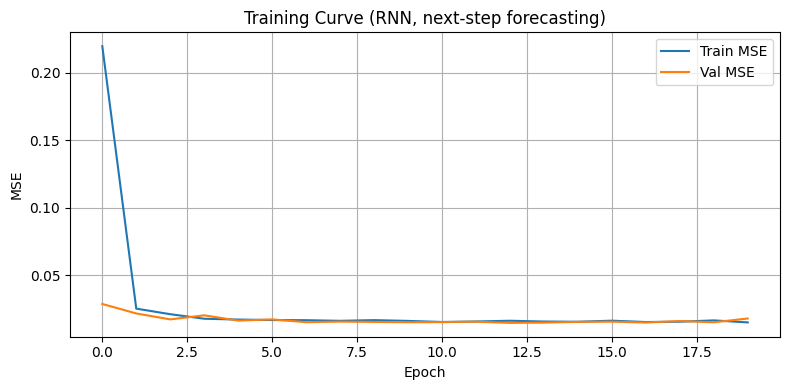

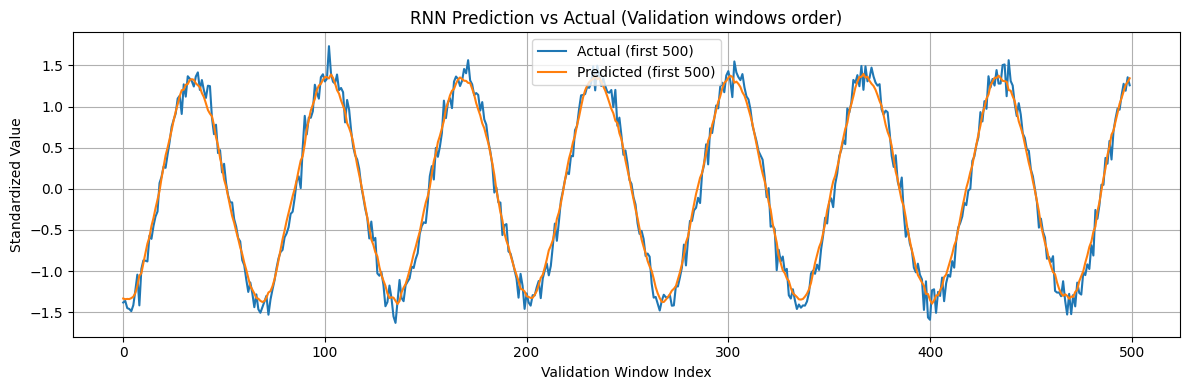

Example | true: -1.3813 | pred: -1.3332


In [27]:

# ---------------------------
# 7) 학습 곡선 시각화
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(train_history, label="Train MSE")
plt.plot(val_history,   label="Val MSE")
plt.title("Training Curve (RNN, next-step forecasting)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# 8) 검증 구간에서 "예측 vs 실제" 비교 시각화
#    - 검증 DataLoader 순서대로 예측을 모아서 선 그래프로 비교
#    - 완벽 정렬(원시 타임스탬프 기준 복원)까지는 아니어도,
#      예측이 실제 패턴을 따라가는지 직관적으로 확인 가능
# ---------------------------
model.eval()
preds, trues = [], []
with torch.no_grad():
    for X, y in val_dl:
        X = X.to(device).float()
        y = y.to(device).float()
        yhat = model(X)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

preds = torch.cat(preds, dim=0).squeeze(-1).numpy()
trues = torch.cat(trues, dim=0).squeeze(-1).numpy()

plt.figure(figsize=(12,4))
plt.plot(trues[:500], label="Actual (first 500)")
plt.plot(preds[:500], label="Predicted (first 500)")
plt.title("RNN Prediction vs Actual (Validation windows order)")
plt.xlabel("Validation Window Index")
plt.ylabel("Standardized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# 9) 단일 예시: 검증 첫 샘플로 true/pred 출력
# ---------------------------
X0, y0 = next(iter(val_dl))
with torch.no_grad():
    y0_hat = model(X0.to(device).float()).cpu()

print(f"Example | true: {y0[0].item():.4f} | pred: {y0_hat[0].item():.4f}")


[Epoch 01] train_mse=0.141919 | val_mse=55.533750
[Epoch 02] train_mse=0.002208 | val_mse=52.334498
[Epoch 03] train_mse=0.001954 | val_mse=50.787571
[Epoch 04] train_mse=0.001703 | val_mse=49.271391
[Epoch 05] train_mse=0.001414 | val_mse=47.735012
[Epoch 06] train_mse=0.001245 | val_mse=46.790690
[Epoch 07] train_mse=0.001199 | val_mse=45.800809
[Epoch 08] train_mse=0.001175 | val_mse=44.796932
[Epoch 09] train_mse=0.001179 | val_mse=44.101957
[Epoch 10] train_mse=0.001143 | val_mse=43.316012
[Epoch 11] train_mse=0.001273 | val_mse=42.693285
[Epoch 12] train_mse=0.001225 | val_mse=42.105058
[Epoch 13] train_mse=0.001268 | val_mse=41.378195
[Epoch 14] train_mse=0.001177 | val_mse=40.952615
[Epoch 15] train_mse=0.001116 | val_mse=40.765606
[Epoch 16] train_mse=0.001936 | val_mse=39.625722
[Epoch 17] train_mse=0.000988 | val_mse=39.364199
[Epoch 18] train_mse=0.001603 | val_mse=38.526064
[Epoch 19] train_mse=0.000950 | val_mse=37.978465
[Epoch 20] train_mse=0.001046 | val_mse=37.277213


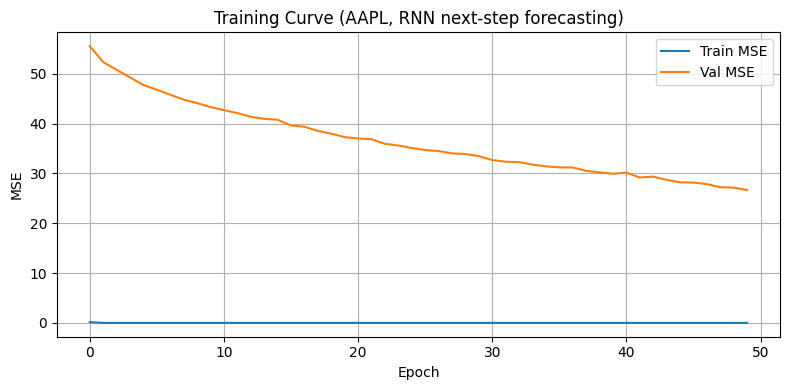

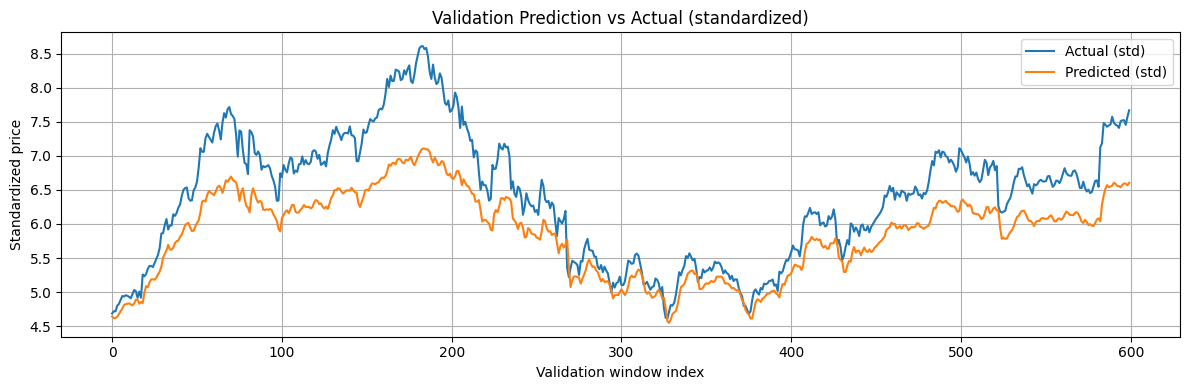

In [31]:
"""
RNN + sklearn StandardScaler로 AAPL 주가 '다음 1일' 예측 (PyTorch)
- 데이터: CSV (일반적으로 Yahoo Finance 형식: Date, Open, High, Low, Close, Adj Close, Volume)
- 입력: 과거 WINDOW일의 종가(또는 조정종가) → (window, 1)
- 출력: 다음 1일 종가 (회귀)
- 포인트:
  * 표준화는 반드시 Train으로만 fit, 그 스케일러로 Train/Val transform (데이터 누수 방지)
  * (batch, seq_len, input_size) = (B, WINDOW, 1)
  * nn.RNN(기본형) + 마지막 은닉 h_n[-1] → Linear(1)
  * gradient clipping으로 RNN 안정화
"""

import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 설정값
# ---------------------------
WINDOW   = 60                # 과거 60일을 보고
EPOCHS   = 50                # 10~30 선에서 시도
BATCH_T  = 128               # 배치 크기
LR       = 1e-3              # 학습률
HIDDEN   = 128                # 은닉 크기(32/64/128)


# ---------------------------
# 1) CSV 로드 & 컬럼 선택 & 정렬
# ---------------------------
df = pd.read_csv("data/AAPL.csv")


use_df = df[['Date', 'Adj Close']].copy()
use_df = use_df.dropna().reset_index(drop=True)

# ---------------------------
# 2) torch 텐서화 전: sklearn 표준화 (Train으로만 fit)
# ---------------------------
values = use_df['Adj Close'].astype(float).values.reshape(-1, 1)  # (N,1)

split_idx = int(len(values) * 0.8)           # 시간 순서 유지 분할
train_np  = values[:split_idx]               # (N_train, 1)
val_np    = values[split_idx:]               # (N_val, 1)

scaler = StandardScaler()
scaler.fit(train_np)                         # ✅ Train으로만 학습

train_std_np = scaler.transform(train_np)    # (N_train, 1)
val_std_np   = scaler.transform(val_np)      # (N_val, 1)

# torch 텐서로 변환 (RNN 준비)
train_std = torch.tensor(train_std_np.squeeze(-1), dtype=torch.float32)  # (N_train,)
val_std   = torch.tensor(val_std_np.squeeze(-1),   dtype=torch.float32)  # (N_val,)

# ---------------------------
# 3) 슬라이딩 윈도우 Dataset
# ---------------------------
class WindowDS(Dataset):
    """
    단변량 시계열(표준화된 1D 텐서)을 윈도우로 자르는 Dataset
    X: (window, 1), y: (1,)
    """
    def __init__(self, series_1d: torch.Tensor, window: int):
        self.series = series_1d
        self.window = window
        self.n = len(series_1d) - window

    def __len__(self):
        return max(self.n, 0)

    def __getitem__(self, idx):
        x = self.series[idx: idx + self.window].unsqueeze(-1)  # (window, 1)
        y = self.series[idx + self.window].unsqueeze(-1)       # (1,)
        return x, y

train_ds = WindowDS(train_std, WINDOW)
val_ds   = WindowDS(val_std,   WINDOW)

train_dl = DataLoader(train_ds, batch_size=BATCH_T, shuffle=True,  drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=256,    shuffle=False, drop_last=False)

# ---------------------------
# 4) RNN 모델 (기본형)
# ---------------------------
class RNNRegressor(nn.Module):
    """
    nn.RNN 기본형: 마지막 은닉 h_n[-1] → Linear(1)
    입력 x: (B, T=WINDOW, 1)
    out   : (B, T, H)
    h_n   : (L*D, B, H)
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=1,
                 nonlinearity="tanh", dropout=0.0, bidirectional=False,
                 batch_first=True):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,  # 'tanh' or 'relu'
            bias=True,
            batch_first=batch_first,    # (B,T,F) 형태
            dropout=dropout,            # num_layers>=2 일 때만 적용
            bidirectional=bidirectional
        )
        out_dim = hidden_size * (2 if bidirectional else 1)
        self.head = nn.Linear(out_dim, 1)

    def forward(self, x):
        out, h_n = self.rnn(x)  # out:(B,T,H), h_n:(L*D,B,H)
        last = h_n[-1]          # (B,H) or (B,2H)
        yhat = self.head(last)  # (B,1)
        return yhat

model = RNNRegressor(input_size=1, hidden_size=HIDDEN)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ---------------------------
# 5) 평가 함수
# ---------------------------
@torch.no_grad()
def evaluate_mse(dataloader):
    model.eval()
    total_loss, total_n = 0.0, 0
    for X, y in dataloader:
        X = X.float()
        y = y.float()
        yhat = model(X)
        loss = criterion(yhat, y)
        total_loss += loss.item() * y.size(0)
        total_n += y.size(0)
    return total_loss / max(total_n, 1)

# ---------------------------
# 6) 학습 루프
# ---------------------------
train_hist, val_hist = [], []
for epoch in range(1, EPOCHS + 1):
    model.train()
    run_loss, n_seen = 0.0, 0
    for X, y in train_dl:
        X = X.float()
        y = y.float()

        optimizer.zero_grad()
        yhat = model(X)         # (B,1)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * y.size(0)
        n_seen   += y.size(0)

    train_mse = run_loss / max(n_seen, 1)
    val_mse   = evaluate_mse(val_dl)
    train_hist.append(train_mse)
    val_hist.append(val_mse)
    print(f"[Epoch {epoch:02d}] train_mse={train_mse:.6f} | val_mse={val_mse:.6f}")

# ---------------------------
# 7) 학습 곡선 시각화
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(train_hist, label="Train MSE")
plt.plot(val_hist,   label="Val MSE")
plt.title("Training Curve (AAPL, RNN next-step forecasting)")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------------------------
# 8) 검증셋 예측 vs 실제 (표준화 스케일)
# ---------------------------
model.eval()
preds_std, trues_std = [], []
with torch.no_grad():
    for X, y in val_dl:
        X = X.float()
        y = y.float()
        yhat = model(X)
        preds_std.append(yhat.cpu())
        trues_std.append(y.cpu())

preds_std = torch.cat(preds_std, dim=0).squeeze(-1).numpy()  # (N_val - WINDOW,)
trues_std = torch.cat(trues_std, dim=0).squeeze(-1).numpy()

plt.figure(figsize=(12,4))
plt.plot(trues_std[:600], label="Actual (std)")
plt.plot(preds_std[:600], label="Predicted (std)")
plt.title("Validation Prediction vs Actual (standardized)")
plt.xlabel("Validation window index"); plt.ylabel("Standardized price")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

